# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

from sklearn.model_selection import train_test_split

In [3]:
#Open the dataframe
df = pd.read_pickle('D:/CUNY Files/capstone/code files/2014_data_LA_SH_V2.pkl')

** Get stats by vessel by month **

** Get voyage stats by month, month will be a proxy for vessel voyage **
- Given the length of vessel voyages between China and California we would not expect to see the same vessel arrive more than once a month, with the possible exception of a vessel that arrives at the beginning of a month and then returns at the end of the month.

In [4]:
#get the unique counts
voyage_stats_all = df.groupby(['vessel_name','month_act']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats_all.reset_index(col_level=1,inplace = True)

In [5]:
voyage_stats_all.shape

(1181, 13)

In [6]:
#view voyage stats in descending order of the number of actual arrival dates per vessel per month
voyage_stats_all.sort_values('actual_arrival_date',ascending = False).head(10)

,vessel_name,month_act,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
998,OOCL KUALA LUMPUR,11,1099,2,1,2,38,22,17,14,976,456,515
555,HANJIN LONG BEACH,10,2382,2,1,2,32,19,18,11,1460,928,1010
991,OOCL ITALY,11,418,2,1,2,17,20,12,11,379,206,225
148,BANGKOK BRIDGE,8,144,2,1,2,18,8,10,10,158,112,124
414,CSCL WINTER,12,377,2,1,2,21,8,19,9,414,245,257
398,CSCL SPRING,12,820,2,1,1,33,10,14,8,1036,464,472
123,BAI CHAY BRIDGE,10,112,1,1,2,13,7,9,8,99,88,88
557,HANJIN LONG BEACH,12,886,2,1,2,27,10,18,8,880,462,493
421,CSCL YELLOW SEA,12,927,2,1,2,32,12,16,7,1106,526,515
300,COSCO EUROPE,10,1869,2,1,2,35,27,20,7,1033,710,744


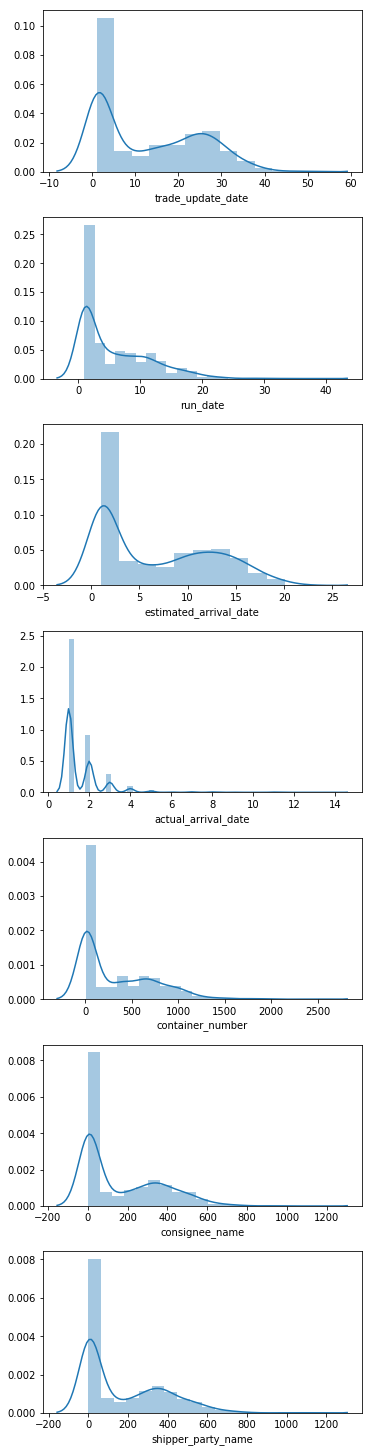

In [7]:
#view all distributions
n = 0
fig, axs = plt.subplots(nrows =7,figsize=(5,20))
for i,x in enumerate(list(voyage_stats_all)[6:]): 
    sns.distplot(voyage_stats_all[x], ax=axs[i])
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)

** View distributions of number of estimated and actual arrival date by vessel for each month **

Text(0.5,1,'distribution of estimated arrival dates per vessel by month')

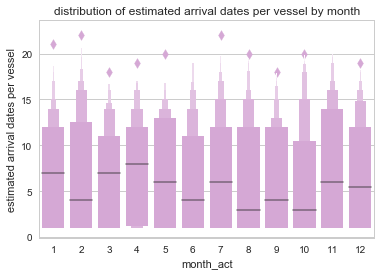

In [8]:
#view the distribution by month of estimated arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="estimated_arrival_date", data=voyage_stats_all, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 60)]

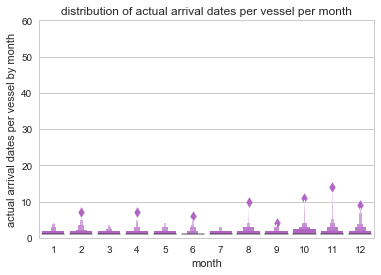

In [9]:
#view the distribution by month of actual arrival dates
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="actual_arrival_date", data=voyage_stats_all, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 60))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

** Compute the correlation between the number of arrival dates per ship and the number of containers per ship **

Text(0.5,1,'container volume distribution by month')

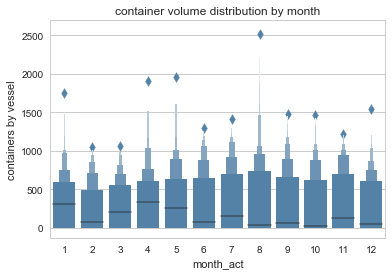

In [10]:
#view the distribution of containers per ship by month
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_act", y="container_number", data=voyage_stats_all, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [11]:
#average actual arrival dates per vessel
print(voyage_stats_all.actual_arrival_date.mean() )

#arrivals per vessel
print(len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]), len(voyage_stats_all))
print(len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]) / (len(voyage_stats_all) * 1.0))

#arrivals per vessel
print(len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]), len(voyage_stats_all))
print(len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 5]) / (len(voyage_stats_all) * 1.0))

1.598645215918713
148 1181
0.12531752751905165
14 1181
0.011854360711261643


In [12]:
#average estimated arrival dates per vessel
print(voyage_stats_all.estimated_arrival_date.mean())

#estimated arrivals per vessel
print(len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]), len(voyage_stats_all))
print(len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 5]) / (len(voyage_stats_all) * 1.0))

#estimated arrivals per vessel
print(len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]), len(voyage_stats_all))
print(len(voyage_stats_all[voyage_stats_all.estimated_arrival_date > 10]) / (len(voyage_stats_all) * 1.0))

6.834885690093142
584 1181
0.4944961896697714
383 1181
0.32430143945808637


In [13]:
#Correlation between the number of actual_arrival_dates and number of containers per ship per month
voyage_stats_all['actual_arrival_date'].corr(voyage_stats_all['container_number'])

0.38655931309345848

Text(0,0.5,'number of actual arrival dates')

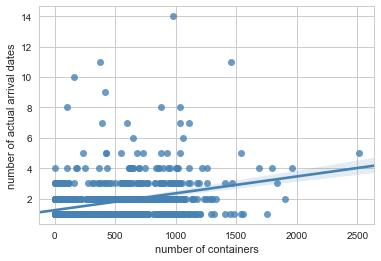

In [14]:
#show the relationship between volume and the number of actual arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="actual_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of actual arrival dates')

In [15]:
#Correlation between the number of estimated_arrival_dates and number of containers per ship per month
voyage_stats_all['estimated_arrival_date'].corr(voyage_stats_all['container_number'])

0.88789282764940547

Text(0,0.5,'number of estimated arrival dates')

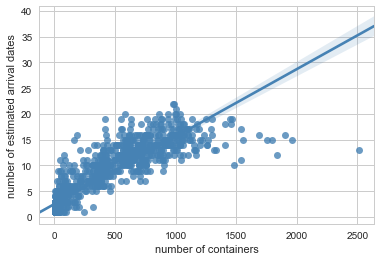

In [16]:
#show the relationship between volume and the number of estimated arrival dates with a scatter plot
ax = sns.regplot(x="container_number", y="estimated_arrival_date", data=voyage_stats_all, color = 'steelblue')
#ax.set(ylim=(-5, 60))
#ax.set(xlim=(-500, 5000))
ax.set_xlabel('number of containers')
ax.set_ylabel('number of estimated arrival dates')